<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion(DDPM)

## 1. Load dataset


In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_3000.zip -d ./data3000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 9.61MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 8.60MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 15.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31

## 2. Import python libraries and define util functions

In [ ]:
!pip install --upgrade diffusers[torch]
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
from diffusers.optimization import get_cosine_schedule_with_warmup
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to visualize the latent space manifold
def plot_latent_space(vae, n=10, digit_size=56):

    # create an empty array to hold the grid of images
    figure = np.zeros((digit_size * n, digit_size * n))

    # generate linear spaces for the x and y axes (latent dimensions)
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    # loop over the grid coordinates and decode latent points to images
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):

            # sample a point (xi, yi) from the latent space and convert to a tensor
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to('cuda')

            # use the decoder to generate an image from the latent vector z_sample
            x_decoded = vae.decoder(z_sample).cpu().detach().numpy()

            # reshape the output to the digit size (56x56)
            digit = x_decoded[0].reshape(digit_size, digit_size)

            # place the generated image into the figure grid at position (i, j)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    # plot the grid of generated images
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

# function for linear interpolation between two points in the latent space
def linear_interpolation(x_from, x_to, steps=10):
    """
    Performs linear interpolation between two points in latent space.

    Args:
    - x_from: Starting latent vector (latent dimension).
    - x_to: Ending latent vector (latent dimension).
    - steps: Number of interpolation steps (default is 10).

    Returns:
    - inter: Interpolated latent vectors between x_from and x_to.
    """
    n = steps + 1  # number of interpolation points (including start and end)

    t_from = x_from  # starting point in the latent space
    t_to = x_to  # ending point in the latent space

    # compute the difference between the two latent vectors
    diff = t_to - t_from

    # initialize an array to store the interpolated vectors
    inter = np.zeros((n, t_from.shape[0]))

    # perform the linear interpolation
    for i in range(n):
        inter[i] = t_from + (i / steps) * diff  # linearly interpolate between the two vectors

    return inter  # return the interpolated vectors


def show_img(images_list,
             r=1,
             cmap='gray',
             img_size=(5, 5),
             axis="off",
             colorbar=False,
             colorbar_range=None,
             save_path=None):
    if r < 1:
        r = 1

    total_images = len(images_list)
    if total_images == 0:
        print("No images to display.")
        return

    cols = (total_images + r - 1) // r
    fig, axs = plt.subplots(r, cols, figsize=(cols * img_size[0], r * img_size[1]))

    if r == 1:
        axs = axs.reshape(1, -1)

    for idx, item in enumerate(images_list):
        ax = axs[0, idx] if r == 1 else axs[idx // cols, idx % cols]
        im = None
        if isinstance(item, Image.Image):
            if item.mode in ['L', '1']:  # Grayscale images
                im = ax.imshow(item, cmap=cmap)
            else:  # Color images
                im = ax.imshow(item)
        elif isinstance(item, np.ndarray):
            if item.ndim == 2:  # 2D array, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D array, color image
                im = ax.imshow(item, cmap=cmap if item.shape[-1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D array with batch dimension of 1
                im = ax.imshow(item[0], cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported numpy array shape: {item.shape}.")
        elif torch.is_tensor(item):
            item = item.detach().cpu().numpy()
            if item.ndim == 2:  # 2D tensor, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D tensor, color image
                im = ax.imshow(item.transpose(1, 2, 0), cmap=cmap if item.shape[0] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D tensor with batch dimension of 1
                im = ax.imshow(item[0].transpose(1, 2, 0), cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported torch tensor shape: {item.shape}.")
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

        if colorbar and im is not None:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im, cax=cax)

        ax.axis(axis)

    plt.tight_layout()
    # 이미지 저장
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data3000/24.0008.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 3000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data3000/'

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
    X.append(img_read(src,file)/255.)  # normalize the image
    Y.append(float(file[:-4]))  # extract label from filename

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

X.shape: (3000, 56, 56) Y.shape: (3000,)


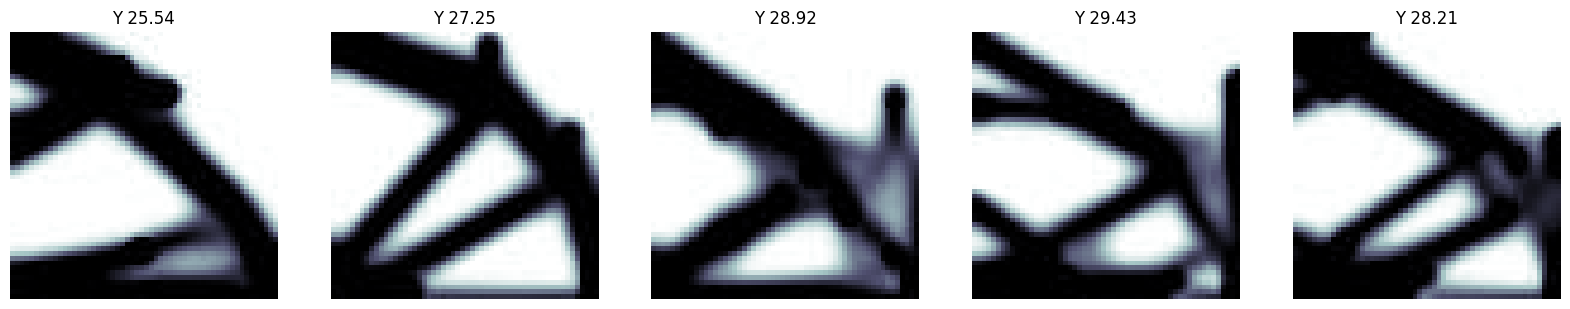

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

In [ ]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
train_images  =  2* train_images - 1
test_images  =  2* test_images - 1
# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels),np.shape(test_labels))
print(type(train_labels), type(test_labels))

# reshape the (image,image) images into (image*image,) size vectors
#train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:]))).astype('float32')
#test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:]))).astype('float32')


print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(train_images),np.shape(test_images)))

# convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32)   # don't need to use labels

(2400, 56, 56) (600, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2400,) (600,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Datasets_train_shape:(2400, 56, 56)  Datasets_test_shape:(600, 56, 56)


## 5. Set to model architecture

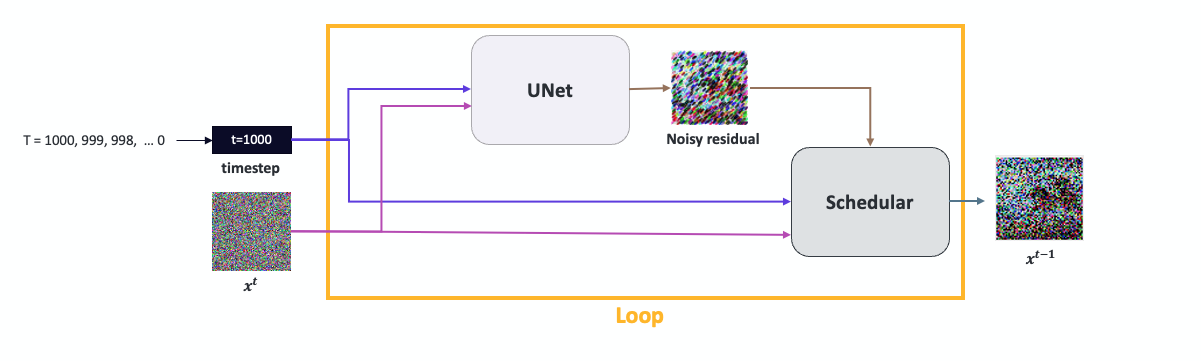

https://github.com/EilieYoun/box/blob/main/images/240214_ddpm.png?raw=true



```
# 코드로 형식 지정됨
```

### UNet architecture

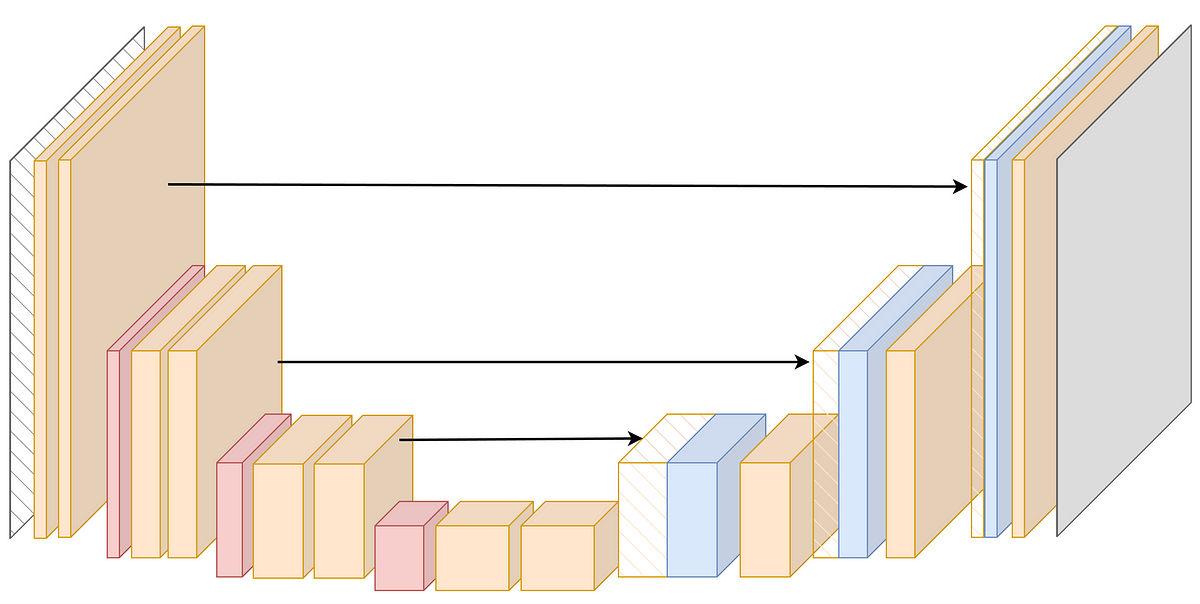

https://towardsdatascience.com/u-net-explained-understanding-its-image-segmentation-architecture-56e4842e313a

In [ ]:
from diffusers import UNet2DModel, DDPMScheduler
unet = UNet2DModel(
    sample_size = 56,
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 1,
    block_out_channels = [64, 128, 256, 512],
).to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

It receives `noisy_images` and `timestep` as inputs and outputs the predicted noise.

torch.Size([4, 1, 56, 56])


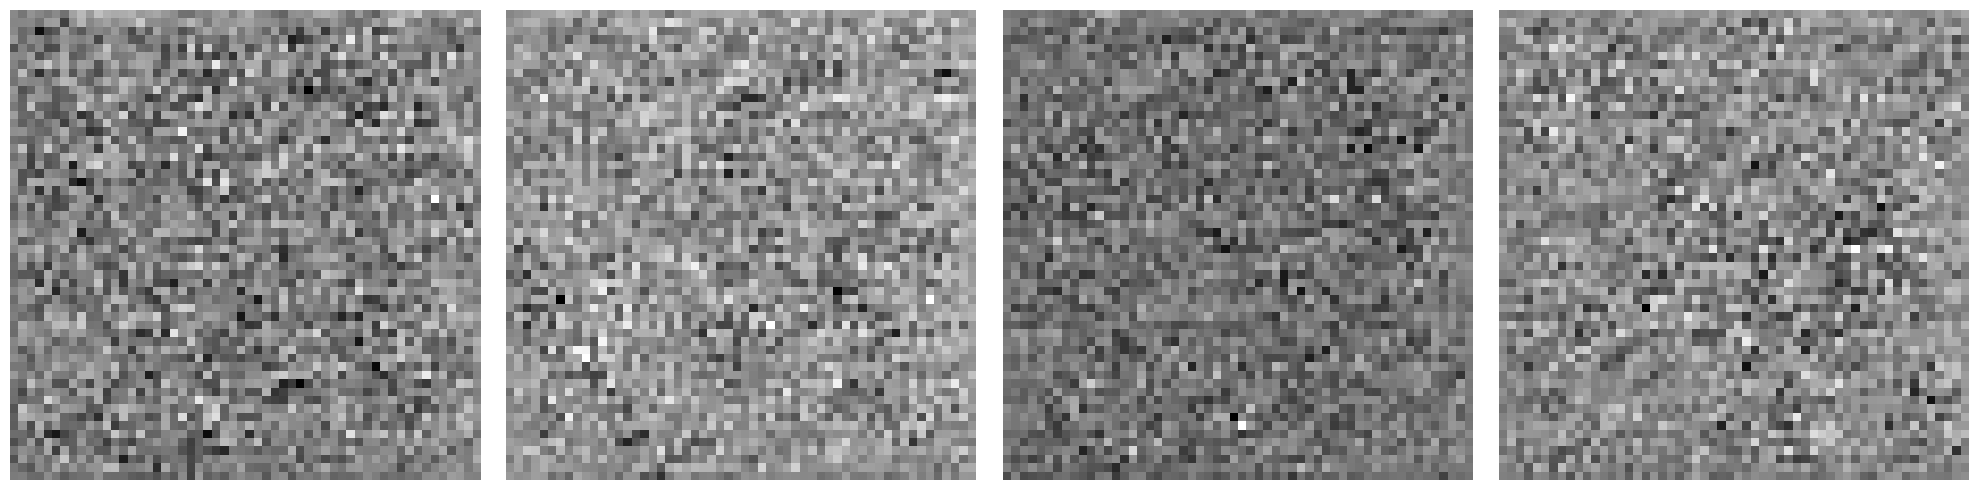

In [ ]:
noisy_images = torch.randn((4, 1, 56, 56)).to(device)
timestep = torch.tensor([10]).to(device)
with torch.no_grad():
    pred_noises = unet(noisy_images, timestep).sample
print(pred_noises.shape)
show_img(pred_noises)

### **| Noise scheduler**

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=600)

In [ ]:
noise_scheduler.set_timesteps(5) # noise scheduler timesteps set up
print('timesteps : ', len(noise_scheduler.timesteps), noise_scheduler.timesteps) # check the timesteps

timesteps :  5 tensor([480, 360, 240, 120,   0])


tensor(480)


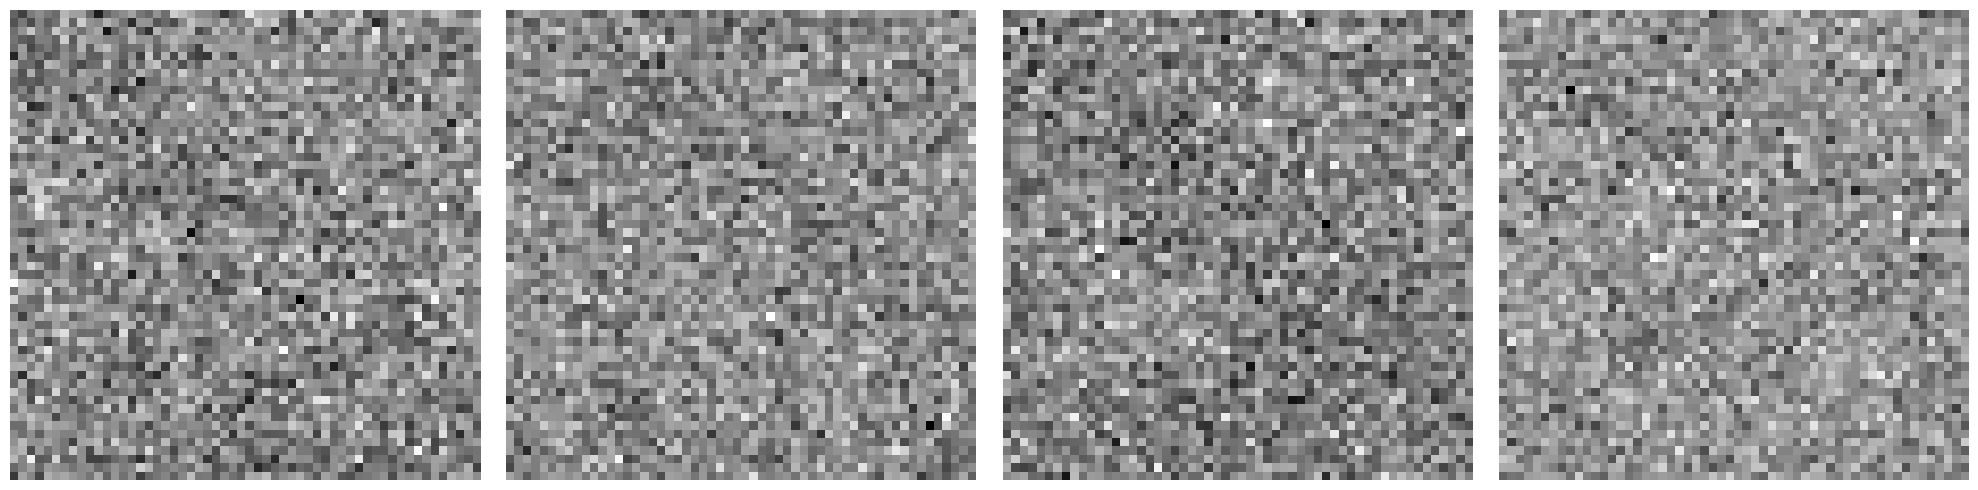

tensor(360)


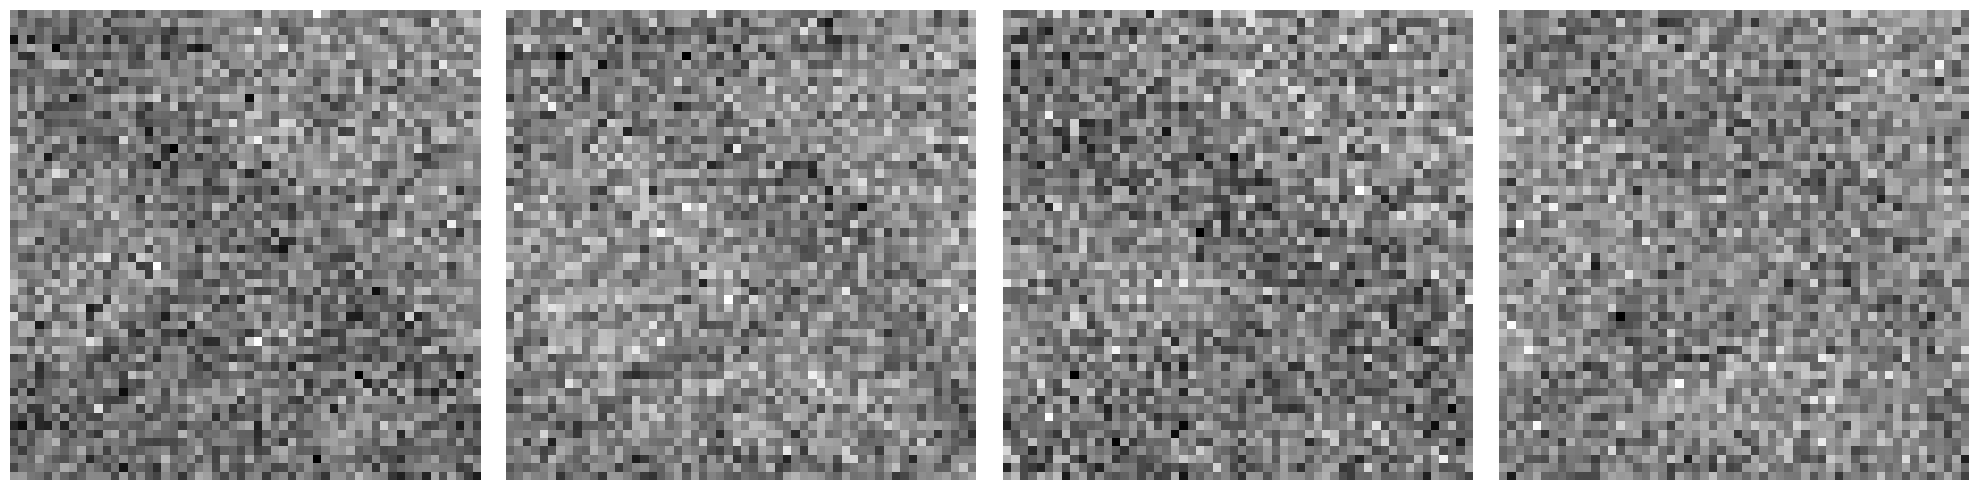

tensor(240)


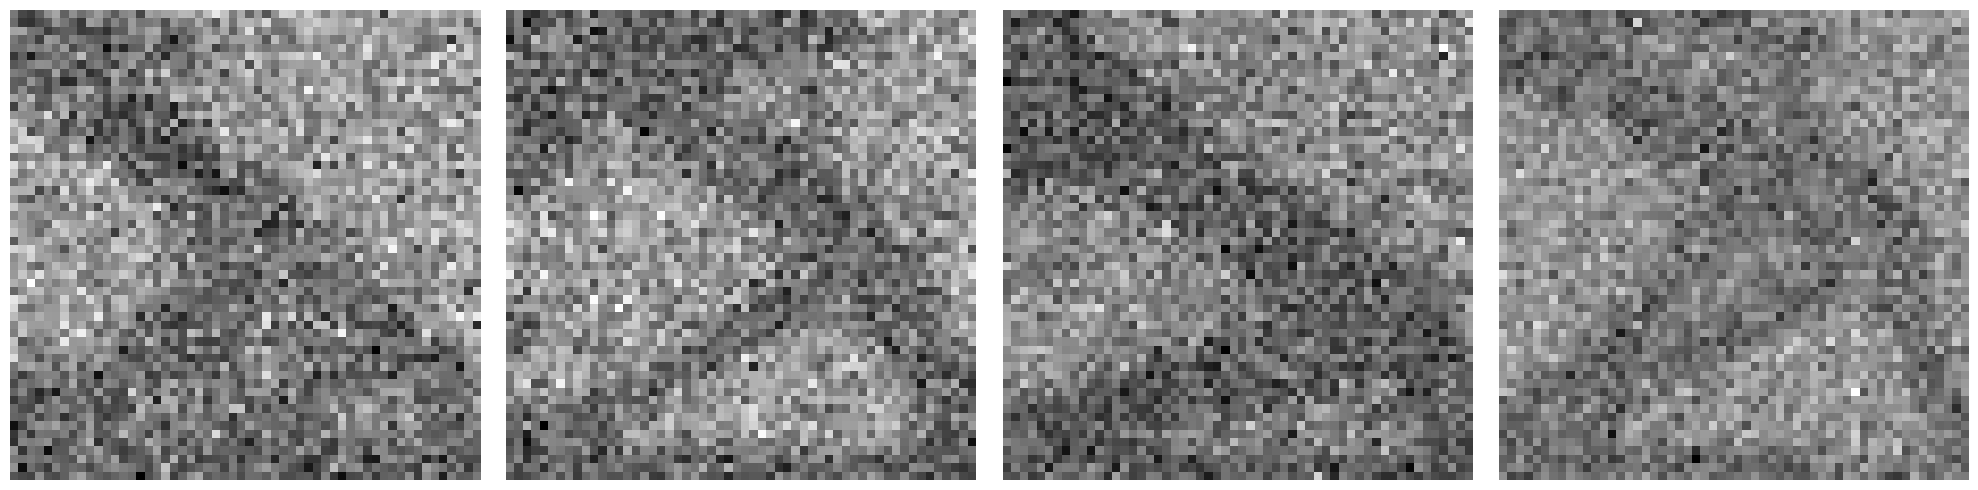

tensor(120)


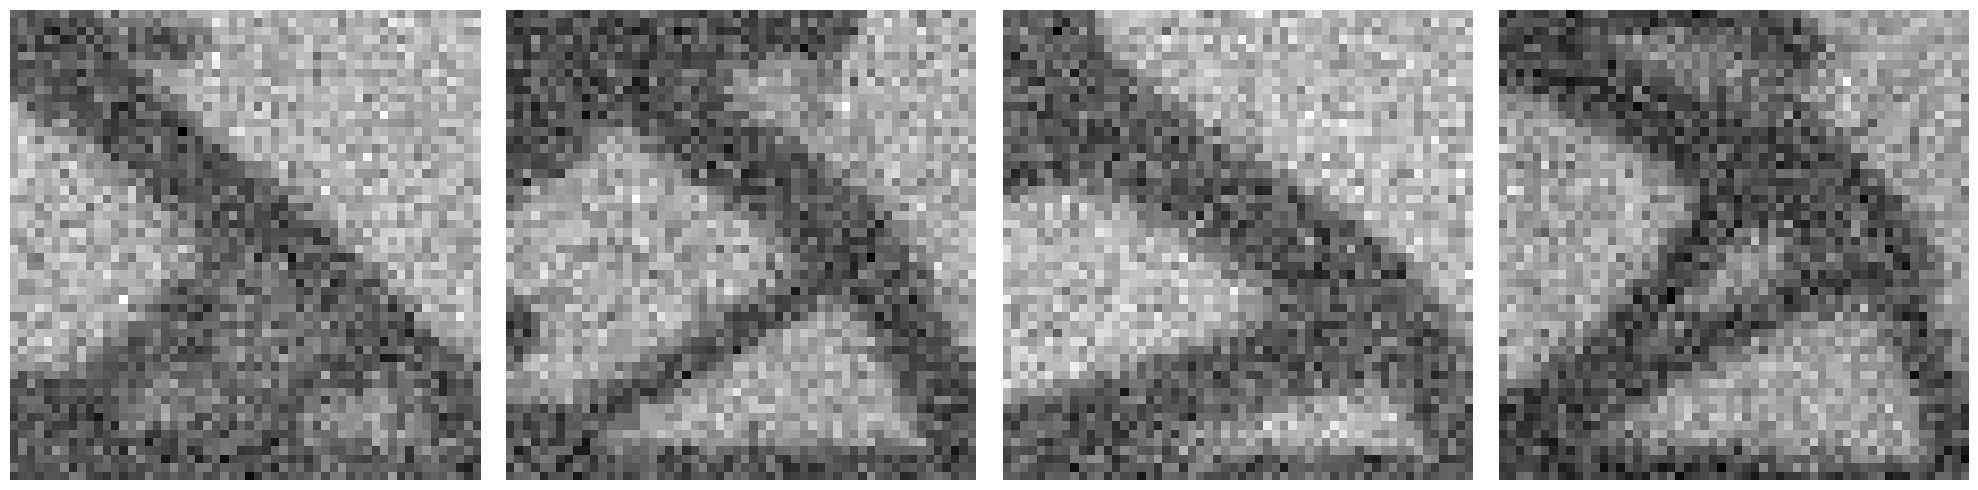

tensor(0)


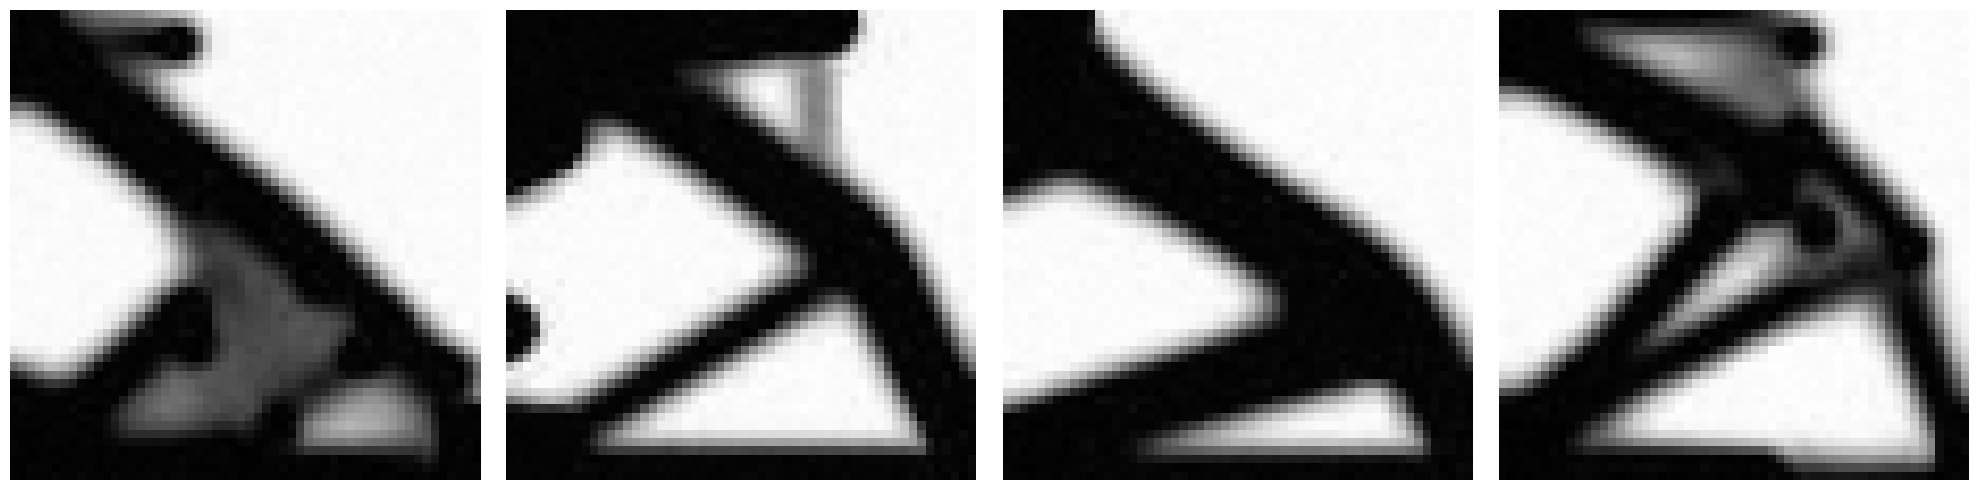

In [ ]:
images = train_images[:4].to(device)
for timestep in noise_scheduler.timesteps:
    print(timestep)

    noises = torch.randn(images.shape).to(device)
    noisy_images = noise_scheduler.add_noise(images, noises, timestep)
    show_img(noisy_images)

### **| Image Denoising Process**

Use UNet and the DDPM Noise Scheduler to implement a progressive restoration of noisy images. Guide codes are available at [Hugging Face DDPM Pipeline] (https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddpm/pipeline_ddpm.py) ).

(4, 1, 56, 56)


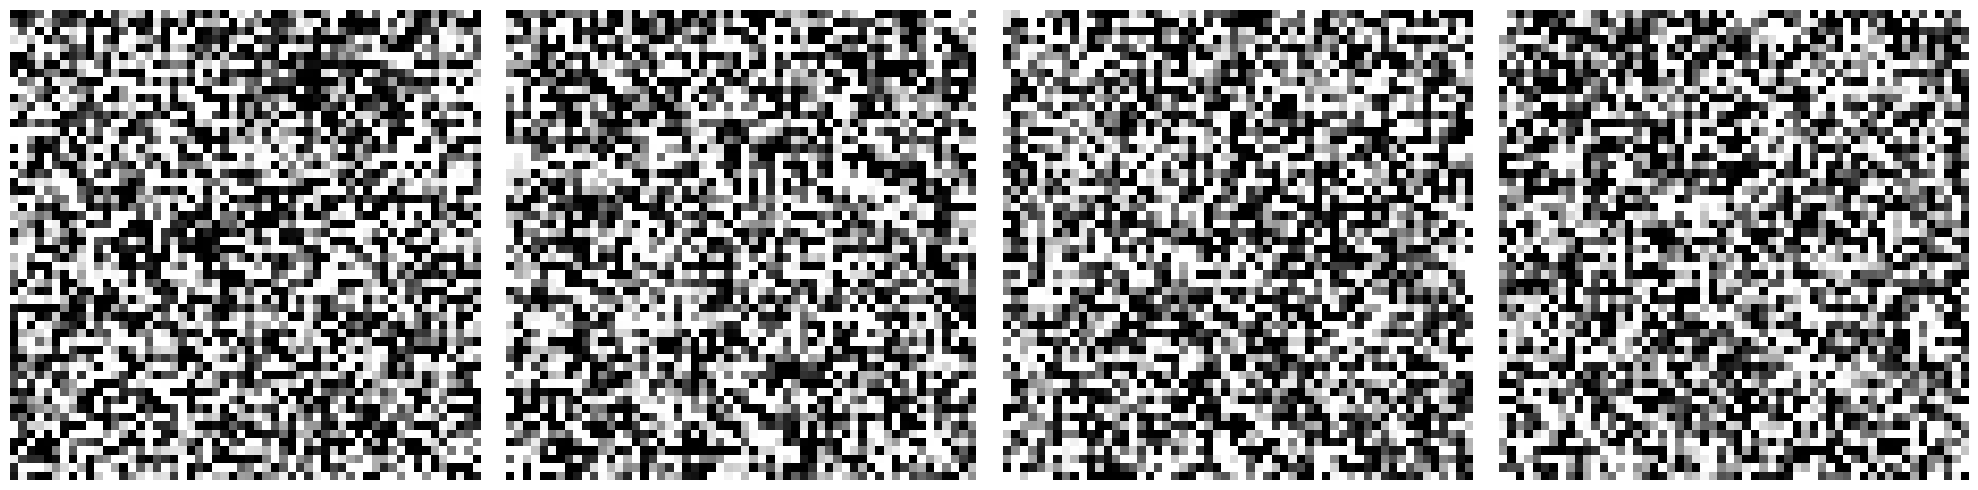

In [ ]:
noise_scheduler.set_timesteps(4) # set up the num of inference steps
images =  torch.randn((4, 1, 56, 56)).to(device) # set up initial noise
for timestep in noise_scheduler.timesteps: # Repeat as many times as timesteps

    with torch.no_grad(): # deactivate gradient calculation
        pred_noises = unet(images, timestep).sample # UNet pipeline
        images  = noise_scheduler.step(pred_noises, timestep, images).prev_sample # denoising step

images = images.cpu().detach().numpy()
print(images.shape)
show_img(images[:,0])

## 6. Set model hyperparameters

### **| Defining the Diffusion Model**

In [ ]:
# model architecture parameters
num_train_timesteps = 600
# If you want to tune DDPM Scheduler, please refer to Huggingface page(https://huggingface.co/docs/diffusers/api/schedulers/ddpm).

# training parameters
num_epochs = 201
batch_size = 64
lr_warmup_steps = 100
seed = 0;
learning_rate = 1e-4
max_norm = 1 # gradient clip
#infer param
n=10;
num_inference_steps=30

#Do not change
sample_size = train_images.shape[1]  # image size (56*56)
in_channels = 1
out_channels = 1


In [ ]:
# You can check detailed parameters setup for UNet in the link below:
# https://huggingface.co/docs/diffusers/api/models/unet2d
unet = UNet2DModel(
    sample_size = sample_size,
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 1,
    block_out_channels = [64, 128, 256, 512],
).to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

In [ ]:
print(unet)

UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, kernel_si

## 7. Train model
- DDPM doesn't have sampling function. So It couldn't check the reconstruction performance.

In [ ]:
from torchvision.utils import save_image
os.makedirs('./Diffusion_samples/', exist_ok = True)

Epoch [1/200], Train_loss: 0.6479


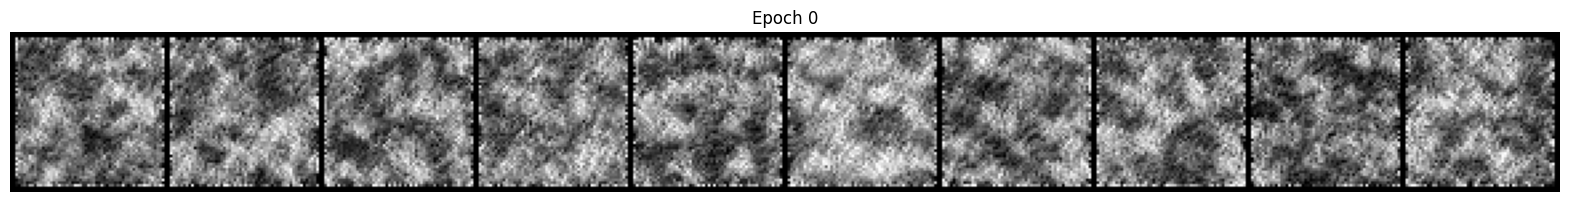

Epoch [2/200], Train_loss: 0.1189


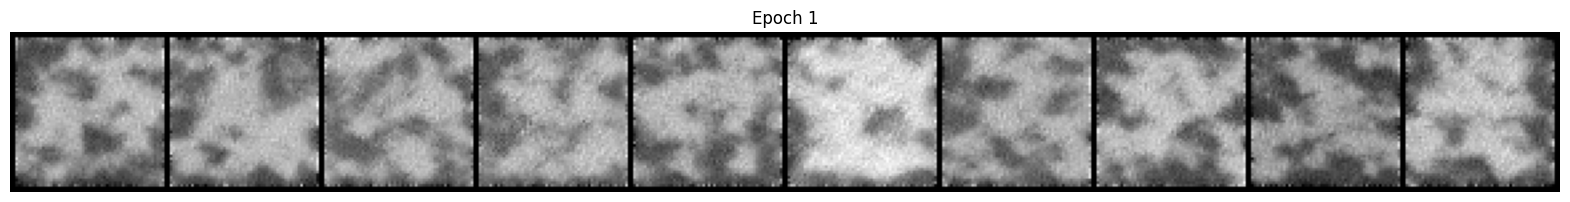

Epoch [3/200], Train_loss: 0.0861
Epoch [4/200], Train_loss: 0.0777
Epoch [5/200], Train_loss: 0.0661
Epoch [6/200], Train_loss: 0.0589
Epoch [7/200], Train_loss: 0.0569
Epoch [8/200], Train_loss: 0.0490
Epoch [9/200], Train_loss: 0.0539
Epoch [10/200], Train_loss: 0.0502
Epoch [11/200], Train_loss: 0.0468
Epoch [12/200], Train_loss: 0.0481
Epoch [13/200], Train_loss: 0.0446
Epoch [14/200], Train_loss: 0.0407
Epoch [15/200], Train_loss: 0.0429
Epoch [16/200], Train_loss: 0.0415
Epoch [17/200], Train_loss: 0.0413
Epoch [18/200], Train_loss: 0.0403
Epoch [19/200], Train_loss: 0.0399
Epoch [20/200], Train_loss: 0.0391
Epoch [21/200], Train_loss: 0.0398


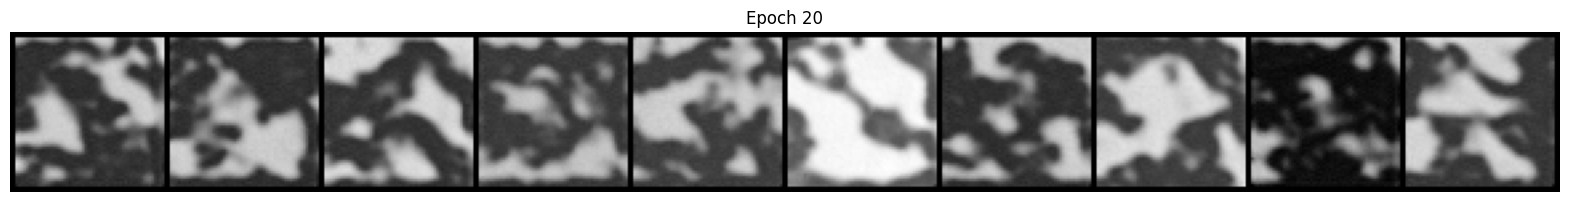

Epoch [22/200], Train_loss: 0.0404
Epoch [23/200], Train_loss: 0.0384
Epoch [24/200], Train_loss: 0.0356
Epoch [25/200], Train_loss: 0.0352
Epoch [26/200], Train_loss: 0.0362
Epoch [27/200], Train_loss: 0.0342
Epoch [28/200], Train_loss: 0.0375
Epoch [29/200], Train_loss: 0.0396
Epoch [30/200], Train_loss: 0.0369
Epoch [31/200], Train_loss: 0.0356
Epoch [32/200], Train_loss: 0.0329
Epoch [33/200], Train_loss: 0.0311
Epoch [34/200], Train_loss: 0.0356
Epoch [35/200], Train_loss: 0.0354
Epoch [36/200], Train_loss: 0.0355
Epoch [37/200], Train_loss: 0.0319
Epoch [38/200], Train_loss: 0.0344
Epoch [39/200], Train_loss: 0.0350
Epoch [40/200], Train_loss: 0.0362
Epoch [41/200], Train_loss: 0.0348


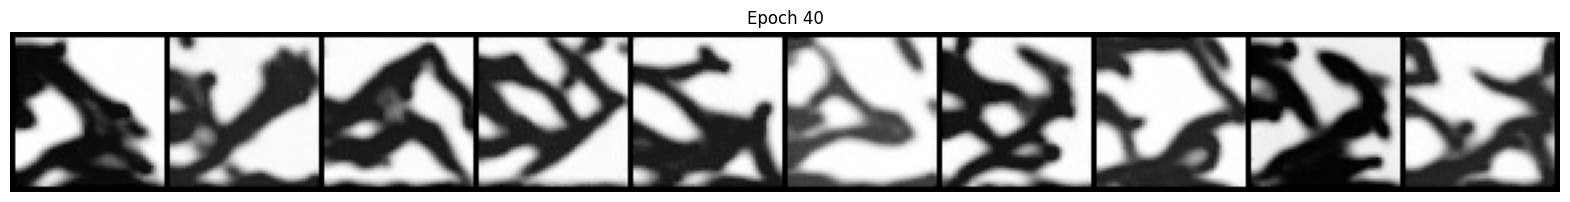

Epoch [42/200], Train_loss: 0.0318
Epoch [43/200], Train_loss: 0.0361
Epoch [44/200], Train_loss: 0.0317
Epoch [45/200], Train_loss: 0.0300
Epoch [46/200], Train_loss: 0.0322
Epoch [47/200], Train_loss: 0.0286
Epoch [48/200], Train_loss: 0.0292
Epoch [49/200], Train_loss: 0.0310
Epoch [50/200], Train_loss: 0.0286
Epoch [51/200], Train_loss: 0.0284
Epoch [52/200], Train_loss: 0.0280
Epoch [53/200], Train_loss: 0.0279
Epoch [54/200], Train_loss: 0.0297
Epoch [55/200], Train_loss: 0.0310
Epoch [56/200], Train_loss: 0.0314
Epoch [57/200], Train_loss: 0.0293
Epoch [58/200], Train_loss: 0.0289
Epoch [59/200], Train_loss: 0.0291
Epoch [60/200], Train_loss: 0.0297
Epoch [61/200], Train_loss: 0.0297


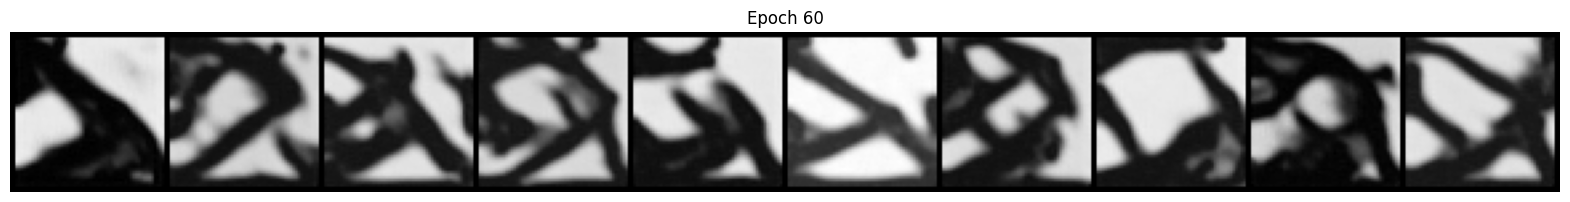

Epoch [62/200], Train_loss: 0.0261
Epoch [63/200], Train_loss: 0.0278
Epoch [64/200], Train_loss: 0.0287
Epoch [65/200], Train_loss: 0.0264
Epoch [66/200], Train_loss: 0.0289
Epoch [67/200], Train_loss: 0.0262
Epoch [68/200], Train_loss: 0.0264
Epoch [69/200], Train_loss: 0.0262
Epoch [70/200], Train_loss: 0.0239
Epoch [71/200], Train_loss: 0.0255
Epoch [72/200], Train_loss: 0.0261
Epoch [73/200], Train_loss: 0.0251
Epoch [74/200], Train_loss: 0.0268
Epoch [75/200], Train_loss: 0.0270
Epoch [76/200], Train_loss: 0.0264
Epoch [77/200], Train_loss: 0.0268
Epoch [78/200], Train_loss: 0.0271
Epoch [79/200], Train_loss: 0.0268
Epoch [80/200], Train_loss: 0.0255
Epoch [81/200], Train_loss: 0.0251


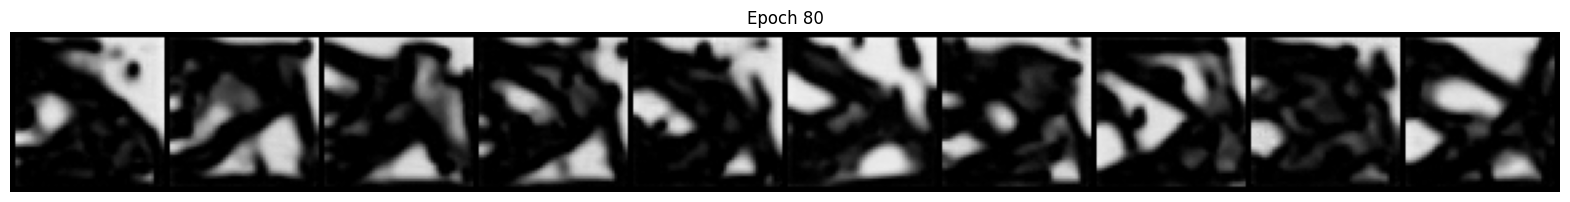

Epoch [82/200], Train_loss: 0.0249
Epoch [83/200], Train_loss: 0.0265
Epoch [84/200], Train_loss: 0.0262
Epoch [85/200], Train_loss: 0.0249
Epoch [86/200], Train_loss: 0.0262
Epoch [87/200], Train_loss: 0.0239
Epoch [88/200], Train_loss: 0.0252
Epoch [89/200], Train_loss: 0.0259
Epoch [90/200], Train_loss: 0.0244
Epoch [91/200], Train_loss: 0.0258
Epoch [92/200], Train_loss: 0.0246
Epoch [93/200], Train_loss: 0.0245
Epoch [94/200], Train_loss: 0.0266
Epoch [95/200], Train_loss: 0.0275
Epoch [96/200], Train_loss: 0.0260
Epoch [97/200], Train_loss: 0.0251
Epoch [98/200], Train_loss: 0.0255
Epoch [99/200], Train_loss: 0.0251
Epoch [100/200], Train_loss: 0.0247
Epoch [101/200], Train_loss: 0.0259


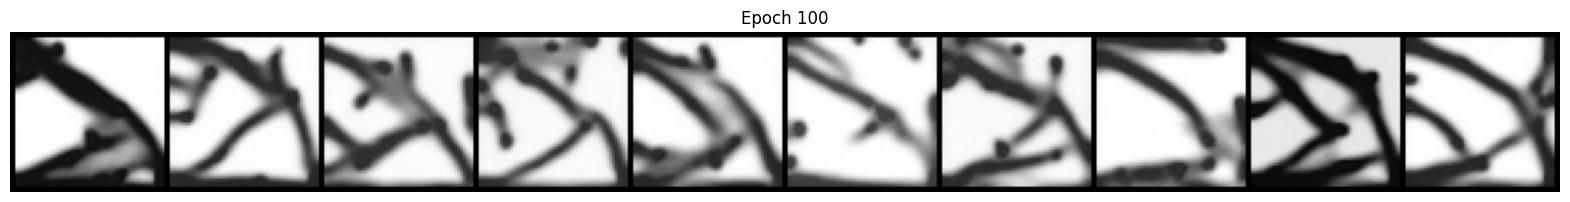

Epoch [102/200], Train_loss: 0.0236
Epoch [103/200], Train_loss: 0.0246
Epoch [104/200], Train_loss: 0.0233
Epoch [105/200], Train_loss: 0.0235
Epoch [106/200], Train_loss: 0.0263
Epoch [107/200], Train_loss: 0.0235
Epoch [108/200], Train_loss: 0.0242
Epoch [109/200], Train_loss: 0.0246
Epoch [110/200], Train_loss: 0.0231
Epoch [111/200], Train_loss: 0.0252
Epoch [112/200], Train_loss: 0.0248
Epoch [113/200], Train_loss: 0.0248
Epoch [114/200], Train_loss: 0.0245
Epoch [115/200], Train_loss: 0.0253
Epoch [116/200], Train_loss: 0.0263
Epoch [117/200], Train_loss: 0.0262
Epoch [118/200], Train_loss: 0.0268
Epoch [119/200], Train_loss: 0.0260
Epoch [120/200], Train_loss: 0.0268
Epoch [121/200], Train_loss: 0.0248


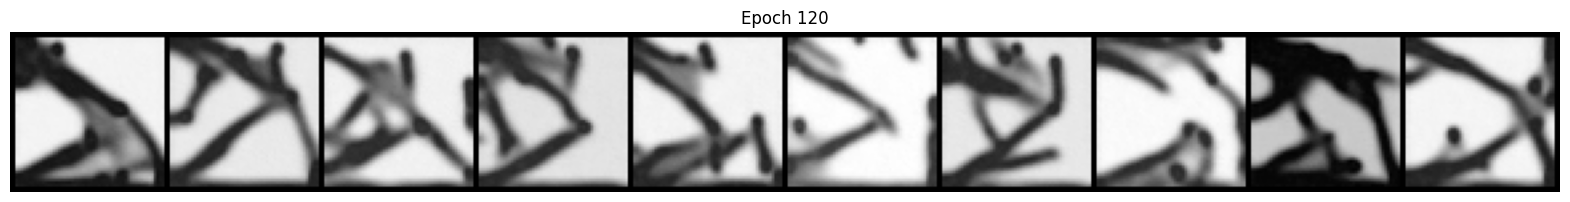

Epoch [122/200], Train_loss: 0.0237
Epoch [123/200], Train_loss: 0.0255
Epoch [124/200], Train_loss: 0.0252
Epoch [125/200], Train_loss: 0.0241
Epoch [126/200], Train_loss: 0.0270
Epoch [127/200], Train_loss: 0.0224
Epoch [128/200], Train_loss: 0.0238
Epoch [129/200], Train_loss: 0.0258
Epoch [130/200], Train_loss: 0.0240
Epoch [131/200], Train_loss: 0.0249
Epoch [132/200], Train_loss: 0.0254
Epoch [133/200], Train_loss: 0.0247
Epoch [134/200], Train_loss: 0.0245
Epoch [135/200], Train_loss: 0.0240
Epoch [136/200], Train_loss: 0.0242
Epoch [137/200], Train_loss: 0.0229
Epoch [138/200], Train_loss: 0.0233
Epoch [139/200], Train_loss: 0.0250
Epoch [140/200], Train_loss: 0.0235
Epoch [141/200], Train_loss: 0.0234


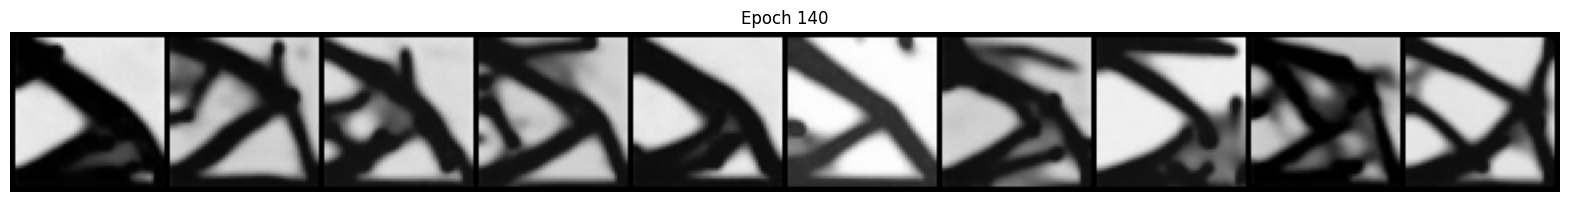

Epoch [142/200], Train_loss: 0.0223
Epoch [143/200], Train_loss: 0.0228
Epoch [144/200], Train_loss: 0.0230
Epoch [145/200], Train_loss: 0.0228
Epoch [146/200], Train_loss: 0.0252
Epoch [147/200], Train_loss: 0.0225
Epoch [148/200], Train_loss: 0.0223
Epoch [149/200], Train_loss: 0.0230
Epoch [150/200], Train_loss: 0.0210
Epoch [151/200], Train_loss: 0.0228
Epoch [152/200], Train_loss: 0.0222
Epoch [153/200], Train_loss: 0.0210
Epoch [154/200], Train_loss: 0.0229
Epoch [155/200], Train_loss: 0.0230
Epoch [156/200], Train_loss: 0.0228
Epoch [157/200], Train_loss: 0.0216
Epoch [158/200], Train_loss: 0.0237
Epoch [159/200], Train_loss: 0.0231
Epoch [160/200], Train_loss: 0.0227
Epoch [161/200], Train_loss: 0.0223


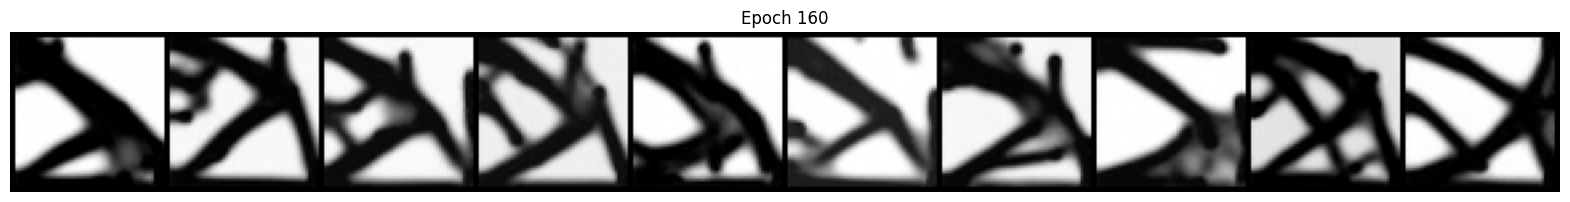

Epoch [162/200], Train_loss: 0.0213
Epoch [163/200], Train_loss: 0.0213
Epoch [164/200], Train_loss: 0.0215
Epoch [165/200], Train_loss: 0.0224
Epoch [166/200], Train_loss: 0.0252
Epoch [167/200], Train_loss: 0.0220
Epoch [168/200], Train_loss: 0.0213
Epoch [169/200], Train_loss: 0.0224
Epoch [170/200], Train_loss: 0.0204
Epoch [171/200], Train_loss: 0.0221
Epoch [172/200], Train_loss: 0.0223
Epoch [173/200], Train_loss: 0.0216
Epoch [174/200], Train_loss: 0.0222
Epoch [175/200], Train_loss: 0.0223
Epoch [176/200], Train_loss: 0.0217
Epoch [177/200], Train_loss: 0.0215
Epoch [178/200], Train_loss: 0.0235
Epoch [179/200], Train_loss: 0.0232
Epoch [180/200], Train_loss: 0.0229
Epoch [181/200], Train_loss: 0.0232


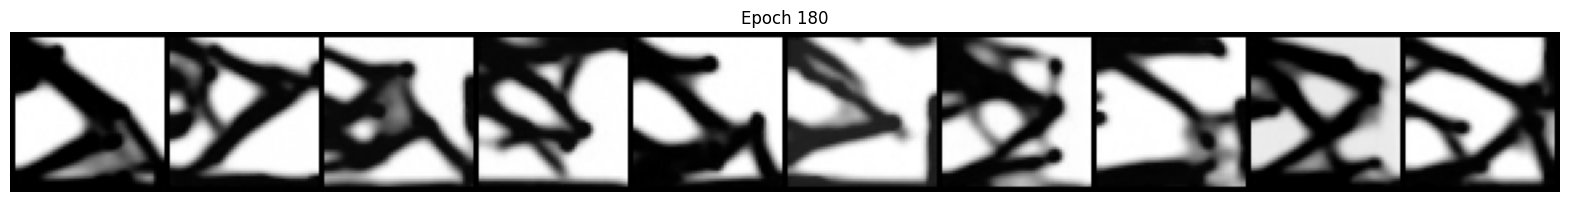

Epoch [182/200], Train_loss: 0.0223
Epoch [183/200], Train_loss: 0.0234
Epoch [184/200], Train_loss: 0.0218
Epoch [185/200], Train_loss: 0.0219
Epoch [186/200], Train_loss: 0.0249
Epoch [187/200], Train_loss: 0.0224
Epoch [188/200], Train_loss: 0.0219
Epoch [189/200], Train_loss: 0.0229
Epoch [190/200], Train_loss: 0.0207
Epoch [191/200], Train_loss: 0.0222
Epoch [192/200], Train_loss: 0.0219
Epoch [193/200], Train_loss: 0.0212
Epoch [194/200], Train_loss: 0.0223
Epoch [195/200], Train_loss: 0.0224
Epoch [196/200], Train_loss: 0.0236
Epoch [197/200], Train_loss: 0.0230
Epoch [198/200], Train_loss: 0.0227
Epoch [199/200], Train_loss: 0.0220
Epoch [200/200], Train_loss: 0.0204


In [ ]:
# create a DataLoader for the training data
train_dataset = TensorDataset(train_images.unsqueeze(1), train_images.unsqueeze(1))  # labels are not needed in Diffusion
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# fix seed
torch.manual_seed(seed)
random.seed(seed)

output_dir = './'

# define optimizer, lr scheduler
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=(len(train_dataset) * num_epochs),
)

# make output_dir
if output_dir is not None:
    os.makedirs(output_dir, exist_ok=True)

# Train loop
global_step = 0
average_loss_trains = []
for epoch in range(num_epochs):
    unet.train()
    total_loss = 0.0

    for step, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        noise = torch.randn(imgs.shape).to(device)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (imgs.shape[0],),
            device=device
        ).long()
        noisy_images = noise_scheduler.add_noise(imgs, noise, timesteps)
        noise_pred = unet(
            noisy_images,
            timesteps).sample

        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm)
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()
    average_loss_train = total_loss / len(train_loader)
    average_loss_trains.append(average_loss_train)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train:.4f}")
    if epoch % 20 == 0 or epoch ==1:
        generator=torch.manual_seed(seed)
        unet.eval()
        noise_scheduler.set_timesteps(num_inference_steps)
        shape = (n, in_channels, sample_size, sample_size)
        images = torch.randn(shape, generator=generator).to(device) # set up initial noise

        for timestep in noise_scheduler.timesteps:
            with torch.no_grad():
                pred_noises = unet(images.to(device), timestep.to(device)).sample
                images  = noise_scheduler.step(pred_noises, timestep, images, generator=generator).prev_sample
        save_image(images, f"./Diffusion_samples/Diffusion_epoch_{epoch}.png", nrow=10, normalize=True)
        # display the generated images
        plt.figure(figsize=(20, 4))
        img = plt.imread(f"./Diffusion_samples/Diffusion_epoch_{epoch}.png")
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()



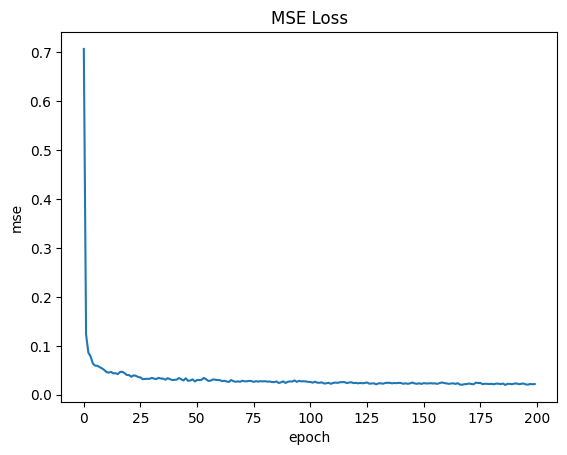

In [ ]:
plt.plot(average_loss_trains)
plt.title("MSE Loss")
plt.xlabel("epoch")
plt.ylabel("mse");

## 8. Image generation

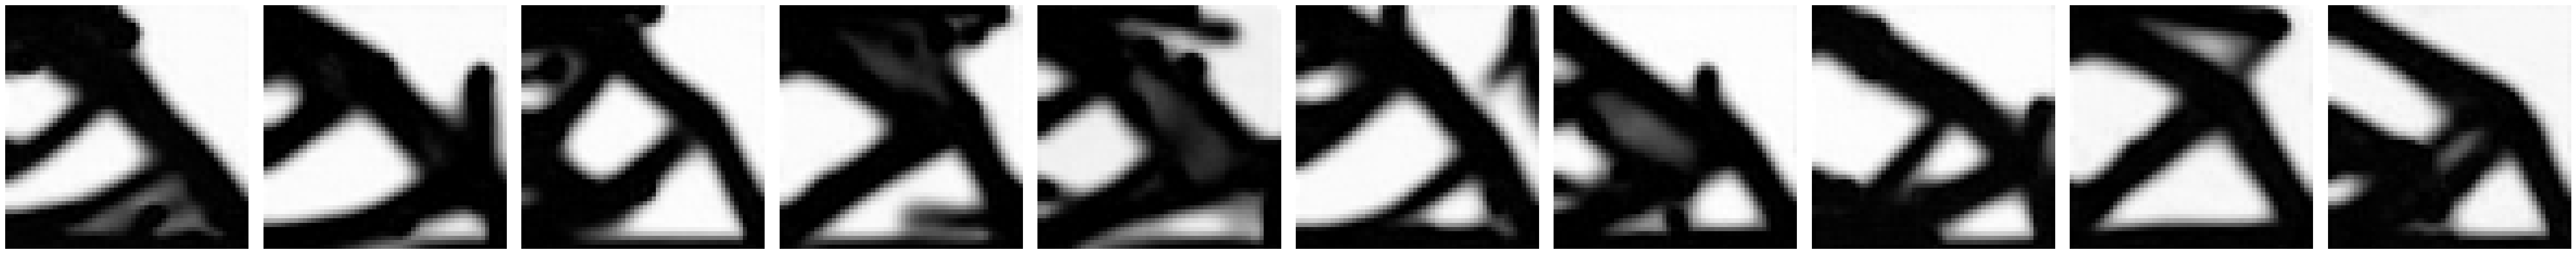

In [ ]:
#INFER MODE
generator=torch.manual_seed(seed+1)
unet.eval()
noise_scheduler.set_timesteps(num_inference_steps)
shape = (n, in_channels, sample_size, sample_size)
images = torch.randn(shape, generator=generator).to(device) # set up initial noise

for timestep in noise_scheduler.timesteps:
    with torch.no_grad():
        pred_noises = unet(images.to(device), timestep.to(device)).sample
        images  = noise_scheduler.step(pred_noises, timestep, images, generator=generator).prev_sample


# End epoch
show_img(
    images)

torch.save(
    unet.state_dict(),
    os.path.join(output_dir,'unet_weights.pth')
)

#model.train(loader, './test', num_epochs=3000)